***Implementing the three moving avg strategy***

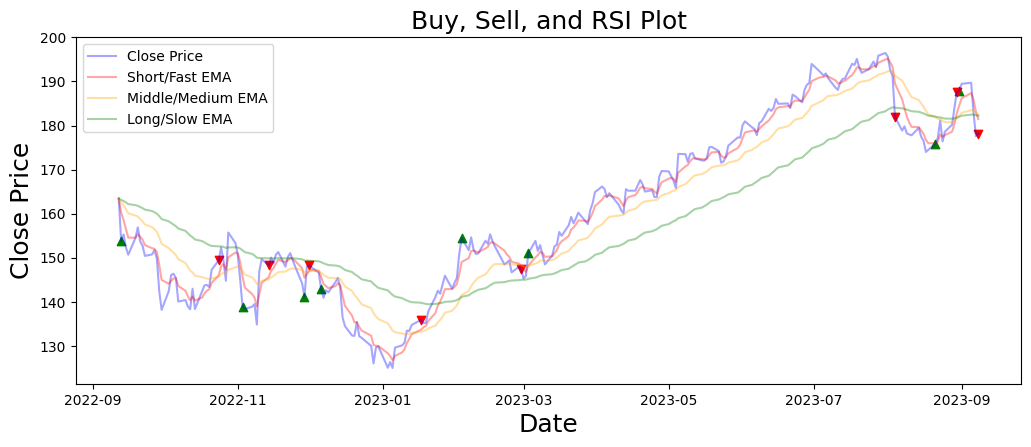

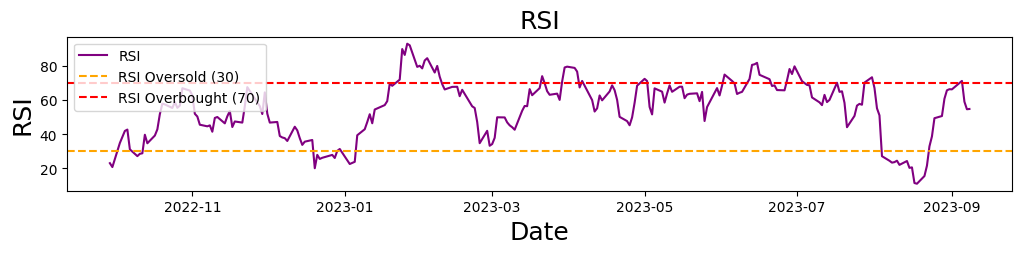

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the dataset
df = pd.read_csv('AAPL.csv')
df = df.set_index(pd.DatetimeIndex(df['Date'].values))

# Define the functions to calculate EMAs
def shortEma(data):
    return data['Close'].ewm(span=5, adjust=False).mean()

def middleEma(data):
    return data['Close'].ewm(span=21, adjust=False).mean()

def longEma(data):
    return data['Close'].ewm(span=63, adjust=False).mean()

# Calculate the EMAs by calling the functions with your DataFrame as an argument
df['Short'] = shortEma(df)
df['Middle'] = middleEma(df)
df['Long'] = longEma(df)

# Define the buy/sell function (as provided in your previous code)
def buy_sell_function(data):
    buy_list, sell_list = [np.nan] * len(data), [np.nan] * len(data)
    flag_long, flag_short = False, False

    for i in range(0, len(data)):
        if (
            data['Short'][i] > data['Middle'][i] and
            data['Middle'][i] > data['Long'][i] and
            flag_long is False and flag_short is False
        ):
            buy_list[i] = data['Close'][i]
            sell_list[i] = np.nan
            flag_long = True
        elif flag_long and data['Short'][i] < data['Middle'][i]:
            sell_list[i] = data['Close'][i]
            buy_list[i] = np.nan
            flag_long = False
        if (
            data['Short'][i] < data['Middle'][i] and
            data['Middle'][i] < data['Long'][i] and
            flag_long is False and flag_short is False
        ):
            buy_list[i] = data['Close'][i]
            sell_list[i] = np.nan
            flag_short = True
        elif flag_short and data['Short'][i] > data['Middle'][i]:
            sell_list[i] = data['Close'][i]
            buy_list[i] = np.nan
            flag_short = False
    return buy_list, sell_list

df['Buy'], df['Sell'] = buy_sell_function(df)

# Addressing the missing values by calculating rsi the strategy used here was to classify stocks overbought if rsi > 70  and 
# Stocks oversold when rsi < 30. When both these conditions are met I classified it as 1 
# calculated the rsi 
n = 14  # RSI period
price_changes = df['Close'].diff()
gain = price_changes.where(price_changes > 0, 0)
loss = -price_changes.where(price_changes < 0, 0)
average_gain = gain.rolling(n).mean()
average_loss = loss.rolling(n).mean()
relative_strength = average_gain / average_loss
rsi = 100 - (100 / (1 + relative_strength))
df['RSI'] = rsi

# Visualize the closing price, EMAs, buy/sell signals, and RSI
plt.figure(figsize=(12.2, 4.5))
plt.title('Buy, Sell, and RSI Plot', fontsize=18)
plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.35)
plt.plot(df['Short'], label='Short/Fast EMA', color='red', alpha=0.35)
plt.plot(df['Middle'], label='Middle/Medium EMA', color='orange', alpha=0.35)
plt.plot(df['Long'], label='Long/Slow EMA', color='green', alpha=0.35)
plt.scatter(df.index, df['Buy'], color='green', marker='^', alpha=1)
plt.scatter(df.index, df['Sell'], color='red', marker='v', alpha=1)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()  # Add a legend to the plot

# Create a subplot for the RSI
plt.figure(figsize=(12.2, 2))
plt.title('RSI', fontsize=18)
plt.plot(df['RSI'], label='RSI', color='purple')
plt.axhline(30, linestyle='--', color='orange', label='RSI Oversold (30)')
plt.axhline(70, linestyle='--', color='red', label='RSI Overbought (70)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('RSI', fontsize=18)
plt.legend()  # Add a legend to the RSI plot

plt.show()

# Now you have the EMA values, buy/sell signals, and RSI in your DataFrame


***Strategy for handeling missing data for Buy and Sell we will be using the RSI for obtaining clear signals for buying(RSI > 70 then it gets classified as overbought (1),otherwise 0) and selling (RSI < 30 it, then it gets classified as over 1,otherwise 0)*** 

In [14]:
df['Buy_Signal'] = (df['RSI'] > 70).astype(int)
df['Sell_Signal'] = (df['RSI'] < 30).astype(int)
count_sell = (df['Sell_Signal']==1).sum()
count_buy = (df['Buy_Signal'] == 1).sum()
print(f"Number of sell signals {count_sell}\nNumber of buy signals  {count_buy}")


Number of sell signals 27
Number of buy signals  40


***Filtering the Buy_Signal and Sell_Signal***

The target column combines both the buy_signals and sell_signals. 

When we have df[sell_signal] == 1 we are setting df[target] = 0.

When we have df[buy_signal] == 1 we are setting df[target] = 1.


In [18]:
df['Target'] = np.where(df['Sell_Signal'] == 1, 0, np.where(df['Buy_Signal'] == 1, 1, None))
df

,Date,Open,High,Low,Close,Adj Close,Volume,Short,Middle,Long,Buy,Sell,RSI,Buy_Signal,Sell_Signal,Target
2022-09-29,2022-09-29,146.100006,146.720001,140.679993,142.479996,141.639740,128138200,148.363999,154.652778,159.453732,NaN,NaN,23.106550,0,1,0
2022-09-30,2022-09-30,141.279999,143.100006,138.000000,138.199997,137.384979,124925300,144.975998,153.157071,158.789553,NaN,NaN,20.818879,0,1,0
2022-10-10,2022-10-10,140.419998,141.889999,138.570007,140.419998,139.591888,74899000,142.542581,148.834593,156.120688,NaN,NaN,27.237573,0,1,0
2022-10-11,2022-10-11,139.899994,141.350006,138.220001,138.979996,138.160370,77033700,141.355053,147.938720,155.585042,NaN,NaN,28.612882,0,1,0
2022-10-12,2022-10-12,139.130005,140.360001,138.160004,138.339996,137.524139,70433700,140.350034,147.066109,155.046134,NaN,NaN,28.898001,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-17,2023-08-17,177.139999,177.509995,173.479996,174.000000,174.000000,66062900,176.747533,183.331558,182.471287,NaN,NaN,11.444735,0,1,0
2023-08-18,2023-08-18,172.300003,175.100006,171.960007,174.490005,174.490005,61114200,175.995024,182.527780,182.221872,NaN,NaN,11.036243,0,1,0
2023-08-21,2023-08-21,175.070007,176.130005,173.740005,175.839996,175.839996,46311900,175.943348,181.919800,182.022439,175.839996,NaN,15.545500,0,1,0
2023-08-22,2023-08-22,177.059998,177.679993,176.250000,177.229996,177.229996,42084200,176.372230,181.493454,181.872675,NaN,NaN,21.626627,0,1,0


**Data Preprocessing**

***Indepedent Variables,Dependent variables***

Importing Required sklearn libraries 

In [35]:
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDRegressor
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix,classification_report

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


df['Target'] = df['Target'].astype(int)
x, y = df[['Open', 'High', 'Low', 'Close', 'Short', 'Middle', 'Long', 'RSI']].values, df['Target'].values
sc = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)


model = LogisticRegression(solver='liblinear')
model.fit(x_train, y_train)


y_pred = model.predict(x_test)


clas_report = classification_report(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print(f"Classification report:\n{clas_report}\nConfusion matrix:\n{conf_mat}")


Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Confusion matrix:
[[11  0]
 [ 0 10]]
